In [ ]:
!pip install pdf2jpg
!pip install easyocr
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image
from pdf2jpg import pdf2jpg
import numpy as np
import pytesseract
from pytesseract import Output
import spacy
import easyocr

### Convert PDF file to image

In [2]:
inputpath = 'slanted_invoice.pdf'
outputpath = 'output'
result = pdf2jpg.convert_pdf2jpg(inputpath, outputpath, dpi=300, pages="ALL")
print(result)

[{'cmd': ['java', '-jar', '/usr/local/lib/python3.10/dist-packages/pdf2jpg/pdf2jpg.jar', '-i', 'slanted_invoice.pdf', '-o', 'output', '-d', '300', '-p', 'ALL'], 'input_path': 'slanted_invoice.pdf', 'output_pdfpath': 'output/slanted_invoice.pdf_dir', 'output_jpgfiles': ['output/slanted_invoice.pdf_dir/0_slanted_invoice.pdf.jpg']}]


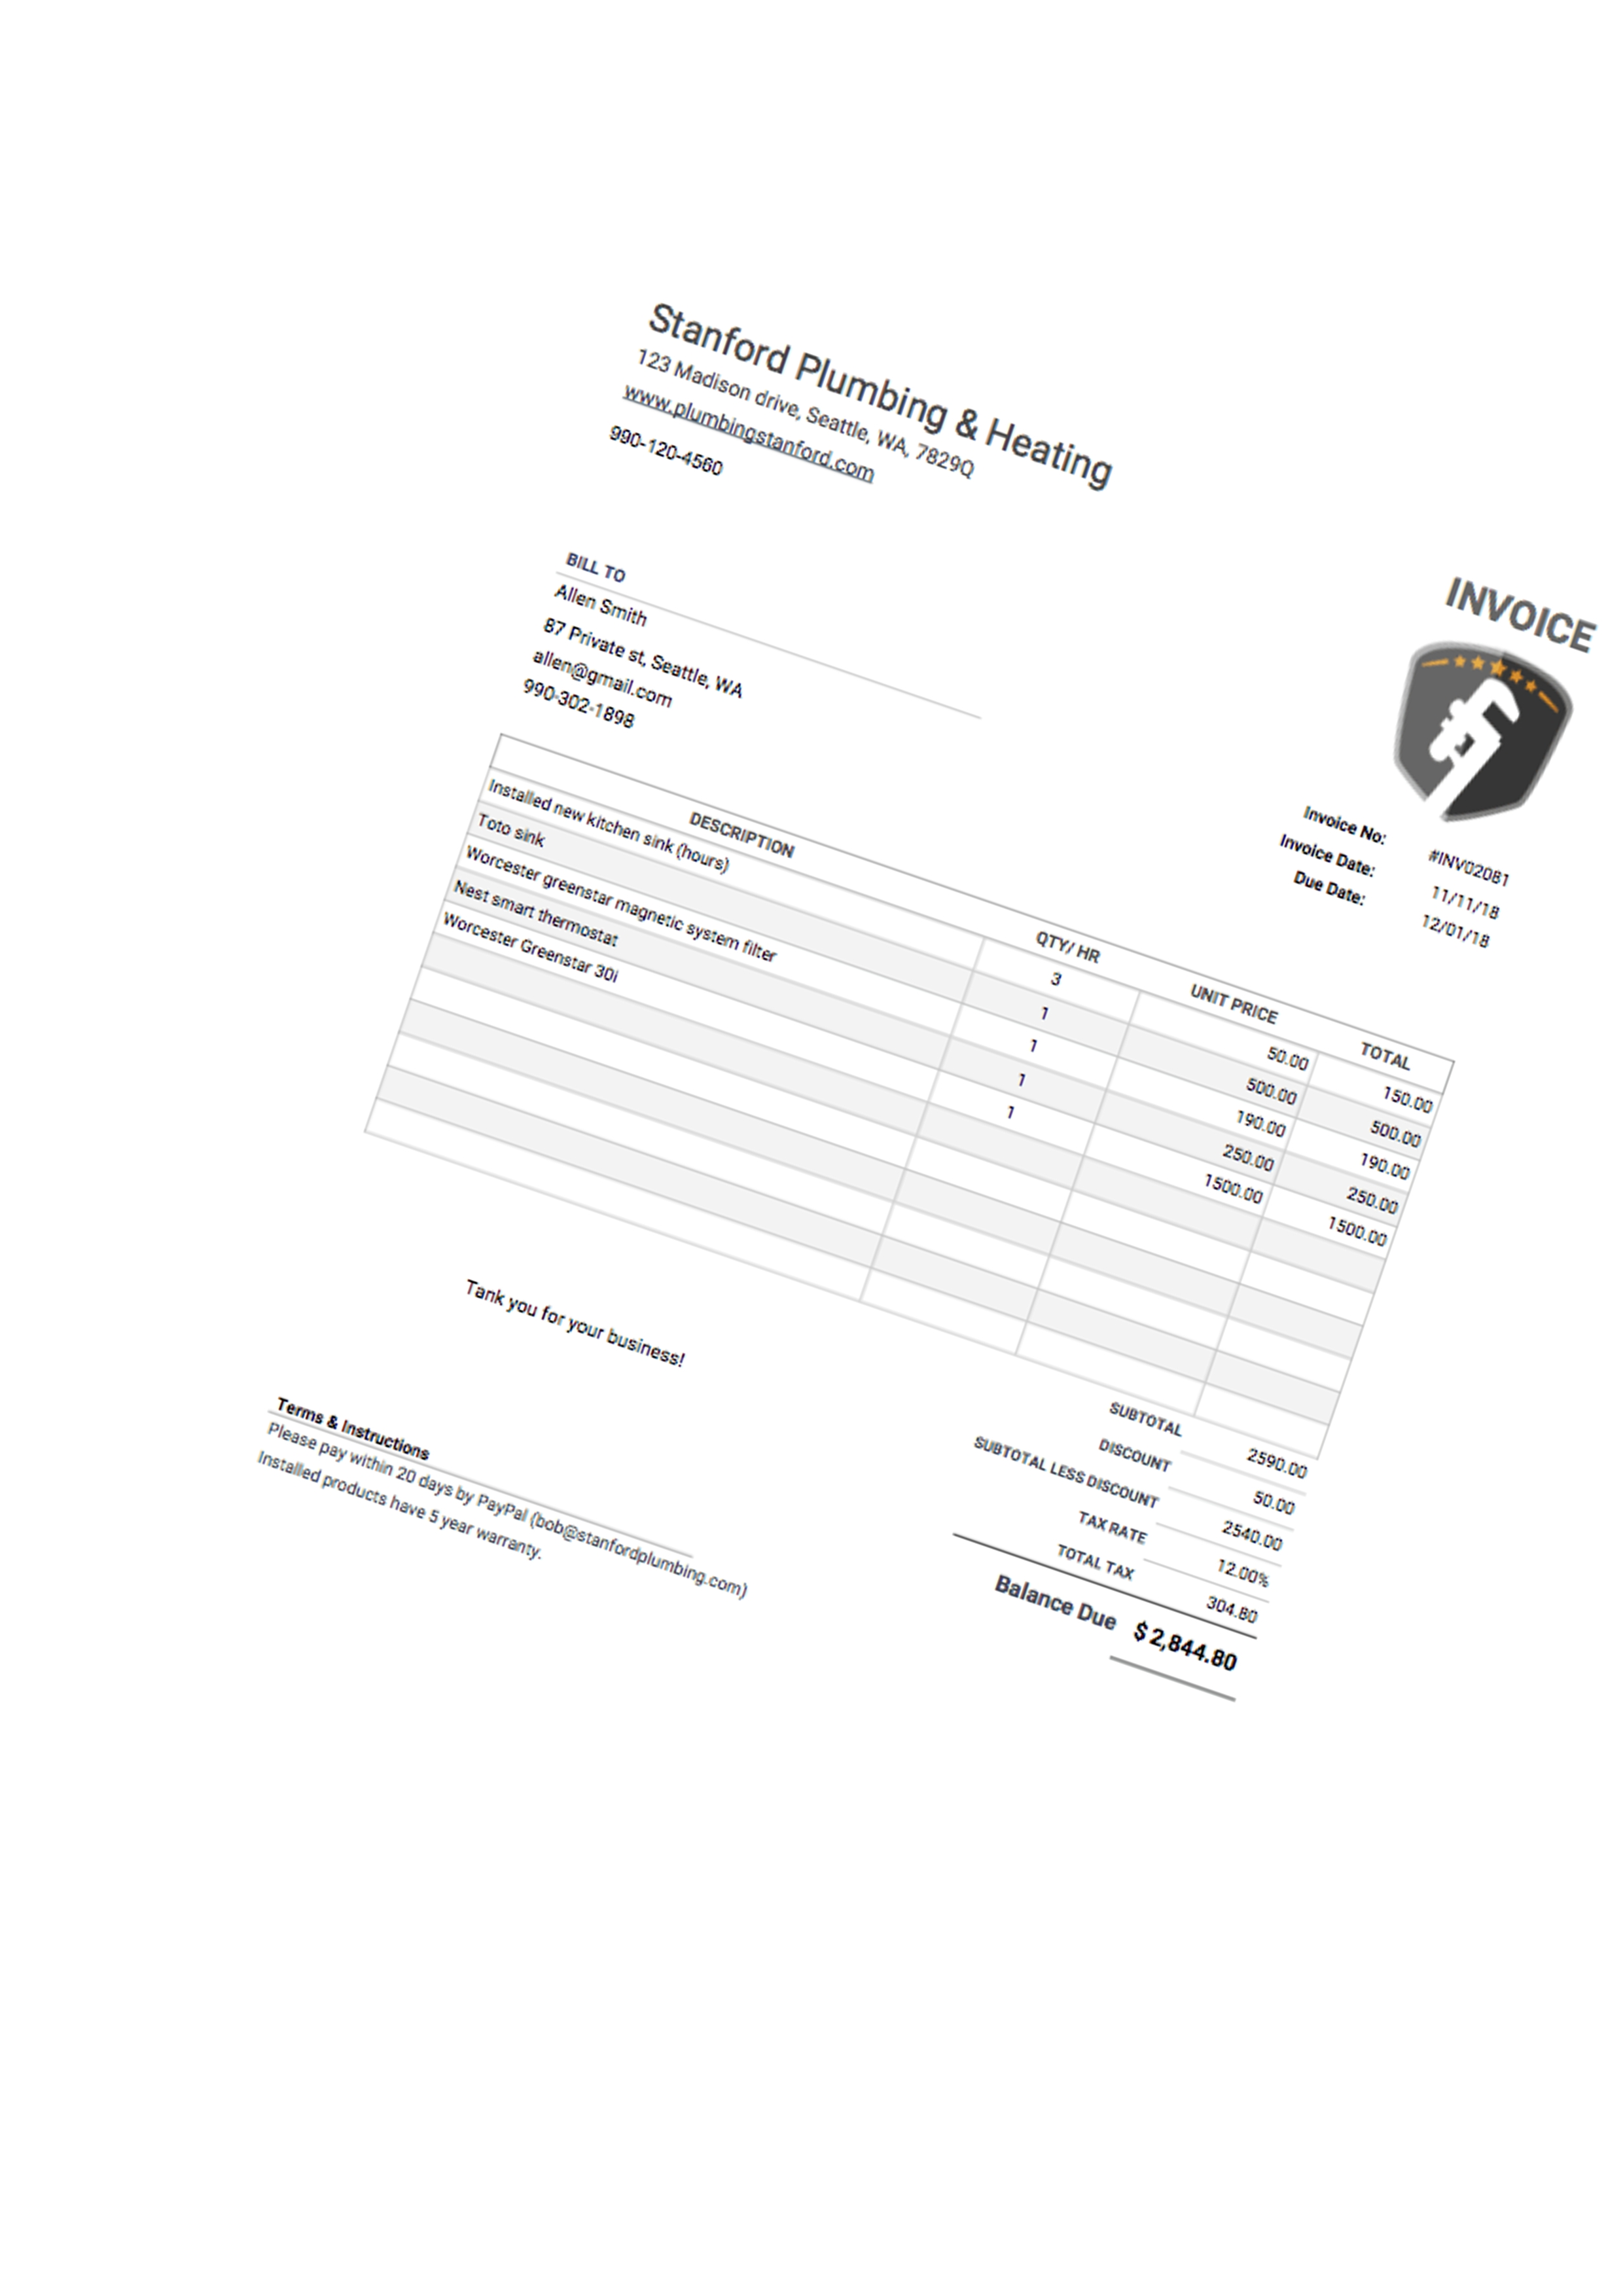

In [3]:
display(Image('output/slanted_invoice.pdf_dir/0_slanted_invoice.pdf.jpg', width=600, height=700))

### Locate and straighten the document

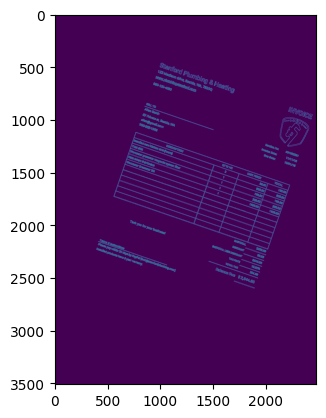

In [4]:
img = cv2.imread('output/slanted_invoice.pdf_dir/0_slanted_invoice.pdf.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edge = cv2.Canny(img, 10, 50)
plt.imshow(edge)

In [5]:
# identify the top_most, bottom_most, left_most and right_most white pixel
# applying thresholding alone was ineffective as the document's white background matched the larger background's white color
top_most = (0, float('inf'))
bottom_most = (0, -float('inf'))
left_most = (float('inf'), 0)
right_most = (-float('inf'), 0)

for y in range(edge.shape[0]):
    for x in range(edge.shape[1]):
        if edge[y, x] == 255:
            # update coordinates if closer to an edge
            if y < top_most[1]: top_most = (x, y)
            if y > bottom_most[1]: bottom_most = (x, y)
            if x < left_most[0]: left_most = (x, y)
            if x > right_most[0]: right_most = (x, y)

In [6]:
points = np.array([[top_most], [bottom_most], [left_most], [right_most]])
hull = cv2.convexHull(points)

In [7]:
rotated_rect = cv2.minAreaRect(hull)
# expand the rectangle dimensions
factor = 50
new_width = rotated_rect[1][0] + factor
new_height = rotated_rect[1][1] + factor
expanded_rect = (rotated_rect[0], (new_width, new_height), rotated_rect[2])
box = cv2.boxPoints(expanded_rect)
box = np.int0(box)

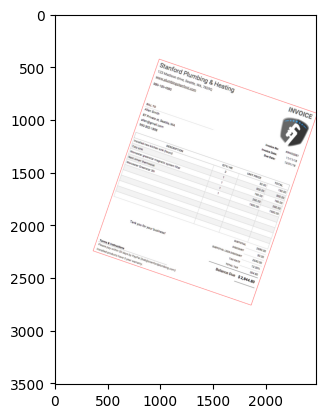

In [8]:
im = img.copy()
cv2.drawContours(im, [box], 0, (255, 0, 0), 2)
plt.imshow(im)

In [9]:
corners = box.tolist()
print(corners)

[[360, 2245], [986, 427], [2482, 942], [1856, 2760]]


In [10]:
def order_rectangle_corners(corners):
    """
    Orders the rectangle corners in top-left, top-right, bottom-right, bottom-left.
    :param corners: List of four (x, y) tuples representing the corners of the rectangle.
    :return: Ordered list of corners.
    """
    # top-left will have the smallest sum of x and y
    top_left, *_, bottom_right = sorted(corners, key=lambda point: point[0] + point[1])
    other_two = [corner for corner in corners if corner not in [top_left, bottom_right]]
    bottom_left = max(other_two, key=lambda point: point[1] - point[0])
    top_right = min(other_two, key=lambda point: point[1] - point[0])

    return [top_left, top_right, bottom_right, bottom_left]

ordered_corners = order_rectangle_corners(corners)
print(ordered_corners)

[[986, 427], [2482, 942], [1856, 2760], [360, 2245]]


In [11]:
def four_point_transform(image, pts):
	(tl, tr, br, bl) = pts
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	M = cv2.getPerspectiveTransform(np.float32([tl, tr, br, bl]), dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	return warped

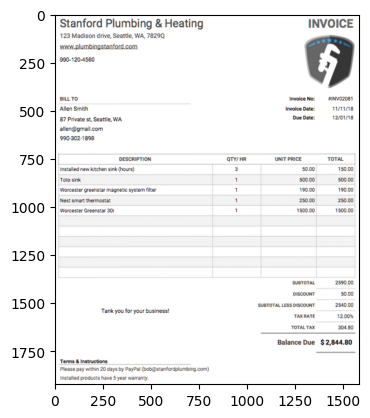

In [12]:
# the straightened image
warped = four_point_transform(img, ordered_corners)
plt.imshow(warped)

### Apply OCR (Pytesseract) to extract texts from the document


In [13]:
extracted_text = pytesseract.image_to_string(warped)
print(extracted_text)

Stanford Plumbing & Heating

123 Madison drive, Seattle, WA, 7829Q

www. plumbingstanford.com
990-120-4560

BILLTO
Allen Smith
87 Private st, Seattle, WA

allen@gmail.com
990-302-1898

DESCRIPTION
installed new kitchen sink (hours)
Toto sink
Worcester greenstar magnetic system filter
Nest smart thermostat
Worcester Greenstar 30)

Tank you for your business!

Terms & Instructions

Please pay within 20 days by PayPal (bob@stanfordplumbing.com)

installed products have 5 year warrenty.

QTY/ HR

INVOICE

 

Invoice No:

Due Date:

SUBTOTAL

DISCOUNT

SUBTOTAL LESS DISCOUNT

TAX RATE

TOTAL TAX

#INVO20B1

1WV/11/18
12/01/18

2590.00
$0.00
2540.00
12.00%
304.60

Balance Due $2,844.80



In [ ]:
results = pytesseract.image_to_data(warped, output_type=Output.DICT)

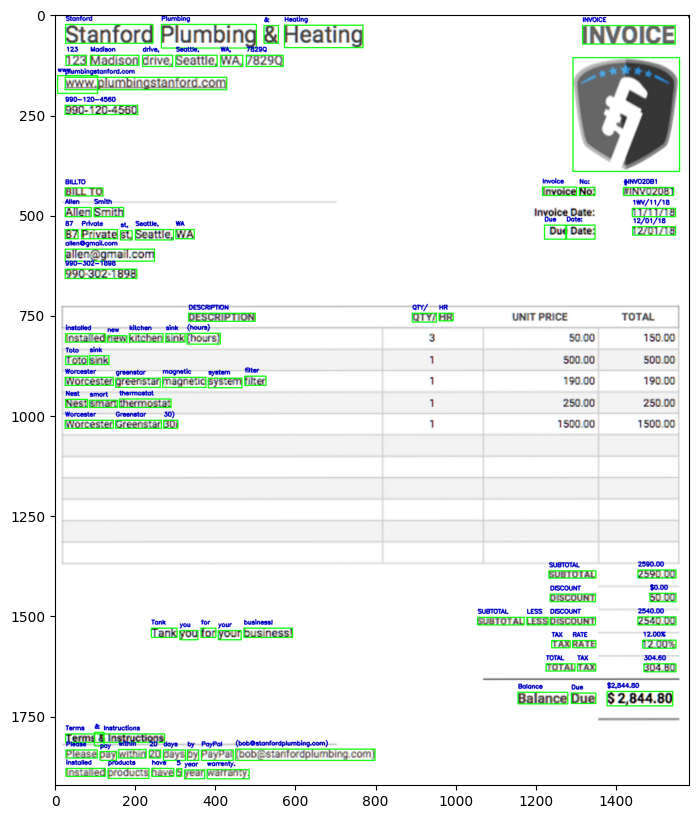

In [15]:
im2 = warped.copy()
for i in range(0, len(results['text'])):
   x = results['left'][i]
   y = results['top'][i]
   w = results['width'][i]
   h = results['height'][i]
   text = results['text'][i]
   conf = int(results['conf'][i])
   if conf >-1:
       text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
       cv2.rectangle(im2, (x, y), (x + w, y + h), (0, 255, 0), 2)
       cv2.putText(im2, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 200), 2)
plt.figure(figsize = (15,10))
plt.imshow(im2)

In [16]:
print(results['text'][:10])

['', '', '', '', 'Stanford', 'Plumbing', '&', 'Heating', '', '']


In [17]:
# concatenate individual elements into single entity, 
# i.e., 'Stanford', 'Plumbing', '&', 'Heating' --> 'Stanford Plumbing & Heating'
concat = ''
indices = []
concat_list = []
for idx, item in enumerate(results['text']):
    if item:
        concat += item + ' '
        indices.append(idx)
    else:
        if concat:
            concat_list.append([concat.strip(), indices])
            concat = ''   # reset concat and indices
            indices = []
# add the last item if it's not empty
if concat:
    concat_list.append([concat.strip(), indices])

# reset bbox coordinates so that each entity is represented by only one bbox
for sublist in concat_list:
  min_id = sublist[1][0]
  max_id = sublist[1][-1]
  xmin = results['left'][min_id]
  ymin = results['top'][min_id]
  xmax = results['left'][max_id] + results['width'][max_id]
  ymax = ymin + results['height'][min_id]
  sublist.append([xmin, ymin, xmax, ymax])
df = pd.DataFrame(concat_list, columns=['entity', 'indices', 'bbox'])
df = df[df['entity'] != '']
df.head(5)

,entity,indices,bbox
0,Stanford Plumbing & Heating,"[4, 5, 6, 7]","[26, 23, 768, 70]"
1,"123 Madison drive, Seattle, WA, 7829Q","[11, 12, 13, 14, 15, 16]","[27, 100, 569, 125]"
2,www. plumbingstanford.com,"[20, 21]","[6, 151, 428, 195]"
3,990-120-4560,[23],"[25, 225, 206, 248]"
4,BILLTO,[27],"[25, 431, 119, 451]"


### Results

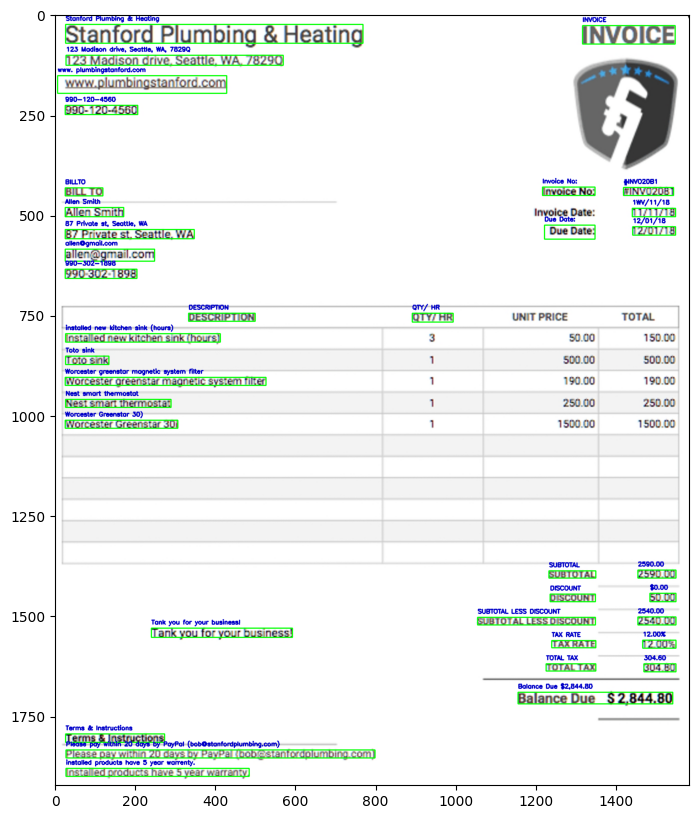

In [18]:
im2 = warped.copy()
for idx, row in df.iterrows():
   x1 = row['bbox'][0]
   y1 = row['bbox'][1]
   x2 = row['bbox'][2]
   y2 = row['bbox'][3]
   text = row['entity']
   cv2.rectangle(im2, (x1, y1), (x2, y2), (0, 255, 0), 2)
   cv2.putText(im2, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 200), 2)
plt.figure(figsize = (15,10))
plt.imshow(im2)

In [19]:
#  extract named entities using SpaCy
def get_labels(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    return [ent.label_ for ent in doc.ents]

In [20]:
df['labels'] = df['entity'].apply(get_labels)
df

,entity,indices,bbox,labels
0,Stanford Plumbing & Heating,"[4, 5, 6, 7]","[26, 23, 768, 70]",[ORG]
1,"123 Madison drive, Seattle, WA, 7829Q","[11, 12, 13, 14, 15, 16]","[27, 100, 569, 125]","[CARDINAL, PERSON, GPE, GPE, DATE]"
2,www. plumbingstanford.com,"[20, 21]","[6, 151, 428, 195]",[]
3,990-120-4560,[23],"[25, 225, 206, 248]",[CARDINAL]
4,BILLTO,[27],"[25, 431, 119, 451]",[]
5,Allen Smith,"[29, 30]","[25, 480, 171, 503]",[PERSON]
6,"87 Private st, Seattle, WA","[32, 33, 34, 35, 36]","[25, 535, 347, 558]","[CARDINAL, GPE]"
7,allen@gmail.com,[40],"[25, 584, 248, 614]",[]
8,990-302-1898,[42],"[25, 634, 204, 657]",[CARDINAL]
9,DESCRIPTION,[46],"[333, 744, 499, 764]",[PERSON]


In [21]:
df.to_csv('entity.csv')

### Pytesseract failed to detect some of the texts; try using EasyOCR (best to use with GPU)

In [22]:
reader = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [25]:
def detect_text(img_path):
    result = reader.detect(img_path, width_ths=0.7,  mag_ratio=1.5)
    text_coor = result[0][0]
    return text_coor #  [x_min, x_max, y_min, y_max]

def draw_bbox(img, bbox):
    result = reader.recognize(img, horizontal_list=bbox, free_list=[])
    result_bbox = zip(result, bbox)
    for r, b in result_bbox:
        text = "".join([c if ord(c) < 128 else "" for c in r[1]]).strip()
        cv2.rectangle(img, (b[0], b[2]), (b[1], b[3]), (0, 255, 0), 2)
        cv2.putText(img, text, (b[0], b[2]+5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 200), 2)
    return img

In [26]:
coors = detect_text(warped)

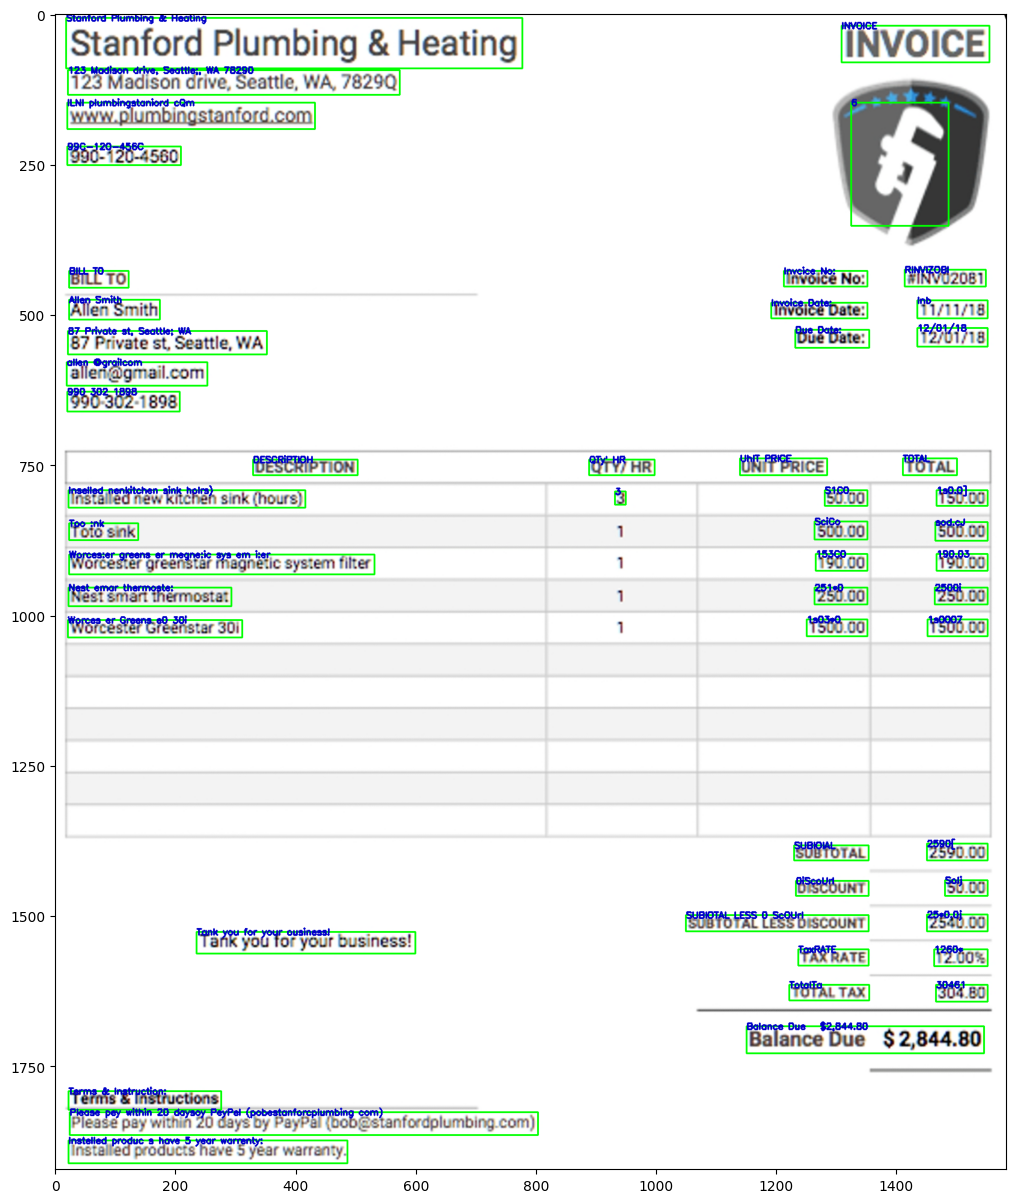

In [27]:
im2 = warped.copy()
draw_bbox(im2, coors)
plt.figure(figsize = (20,15))
plt.imshow(im2)

In [28]:
recognition_results = reader.recognize(warped,horizontal_list=coors,free_list=[])
easy_ocr_result = [txt[1] for txt in recognition_results]
print(easy_ocr_result)

['Stanford Plumbing & Heating', 'INVOICE', '123 Madison drive, Seattle;, WA 78290', 'ILNI plumbingstaniord cQm', '99C-120-456C', '6', 'BILL T0', 'Invcice No:', 'RINVIZOBI', 'Allen Smith', 'Invoice Date:', 'Inb', '87 Private st, Seattle; WA', 'Due Date:', '12/01/18', 'allen @grailcom', '990 302 1898', 'DESCRiPTIOH', "QTy' HR", 'UhIT PRICE', 'TOTAL', 'Inselled nenkitchen sink holrs)', '3', 'S1C0', '1s0.0]', 'Too :nk', 'SciCo', 'sod.cJ', 'Worces:er greens er megne:ic sys em i:er', '153C0', '190.03', 'Nest emar thermoste:', '251*0', '2500i', 'Worces er Greens e0 30i', '1s03*0', '1s0007', 'SUBIOIAL', '2590[', '0iScoUrI', 'Solj', 'SUBIOTAL LESS 0 ScOUrI', '25*0.0j', 'Tank you for your ousiness!', 'TaxRATE', '1260*', 'TotalTa', '30461', 'Balance Due   $2,844.80', 'Terms & Instruction:', 'Please pey within 20 daysoy PeyPel (pobestanforcplumbing com)', 'Instelled produc s have 5 year warrenty:']


EasyOCR is better at detecting text, but PyTesseract is better in text recognition